<a href="https://colab.research.google.com/github/Rogerio-mack/IMT_CD_2025/blob/main/IMT_CD_PSUB1_2025_solucao_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="ITM">
</head>

<img src="https://maua.br/images/selo-60-anos-maua.svg" width=300, align="right">
<!-- <h1 align=left><font size = 6, style="color:rgb(200,0,0)"> optional title </font></h1> -->




# **PSUB1 - ECM514 Ciência de Dados**

In [64]:
#@markdown Nome completo e RA (*\<nome\>, \<RA\>*)
Aluno = 'Daniel Henrique, 1115665' #@param {type:"string"}






In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# **LOD - Length Of the Day**

O dataframe abaixo apresenta a **variação** diária do comprimento do dia em ms, `lod(ms)`. Você pode ver que o LOD vem aumentando ao longo do tempo (**LOD accum**), o que significa que a velocidade de rotação da terra vem diminuindo. Em boa parte isso tem relação com a atividade humana, particularmente grandes construções e grandes deslocamentos e água e terra na **China**.  




In [66]:
df = pd.read_csv('https://github.com/Introducao-Series-Temporais-em-Python/Book/raw/main/Data/Delta_LOD.csv',sep=';',usecols=['year', 'month', 'day', 'lod(ms)', 'sig(ms)'])
df.head()

,year,month,day,lod(ms),sig(ms)
0,1962,1,1,1.723,1.4
1,1962,1,2,1.669,1.4
2,1962,1,3,1.582,1.4
3,1962,1,4,1.496,1.4
4,1962,1,5,1.416,1.4


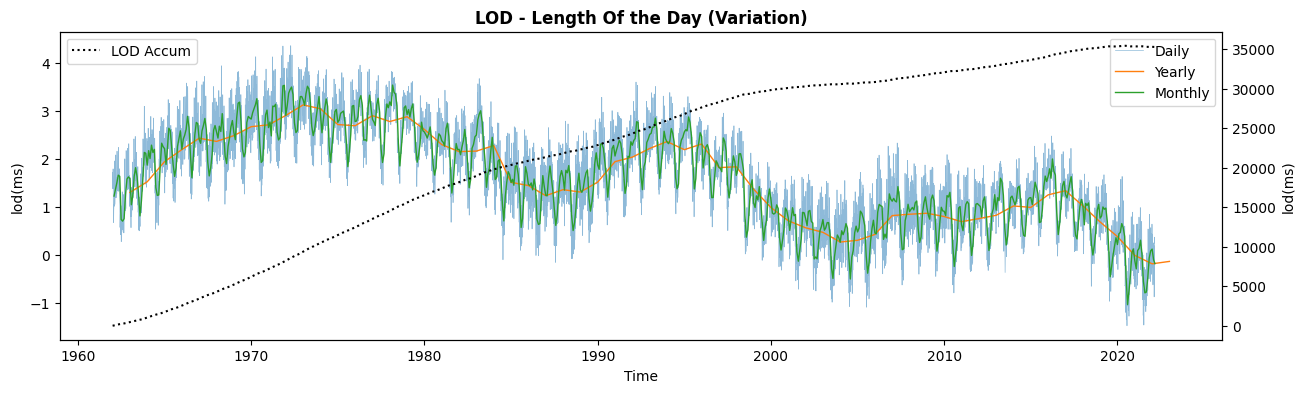

In [67]:
fig, ax = plt.subplots(figsize=(15,4))

df.index = pd.to_datetime(df[["year", "month", "day"]])
df_year = df[['lod(ms)']].resample('YE').mean()
df_month = df[['lod(ms)']].resample('ME').mean()

sns.lineplot(x=df.index, y=df['lod(ms)'],alpha=0.5,label='Daily',ax=ax,lw=0.5)
sns.lineplot(x=df_year.index, y=df_year['lod(ms)'],label='Yearly',ax=ax,lw=1)
sns.lineplot(x=df_month.index, y=df_month['lod(ms)'],label='Monthly',ax=ax,lw=1)

ax2 = ax.twinx()
sns.lineplot(x=df.index, y=df['lod(ms)'].cumsum(),label='LOD Accum',ax=ax2,color='k',linestyle=':')

ax.set_title('LOD - Length Of the Day (Variation)',weight='bold')
ax.set_xlabel('Time')

plt.show()

#### Atenção, ao resample dos os dados acumulados...

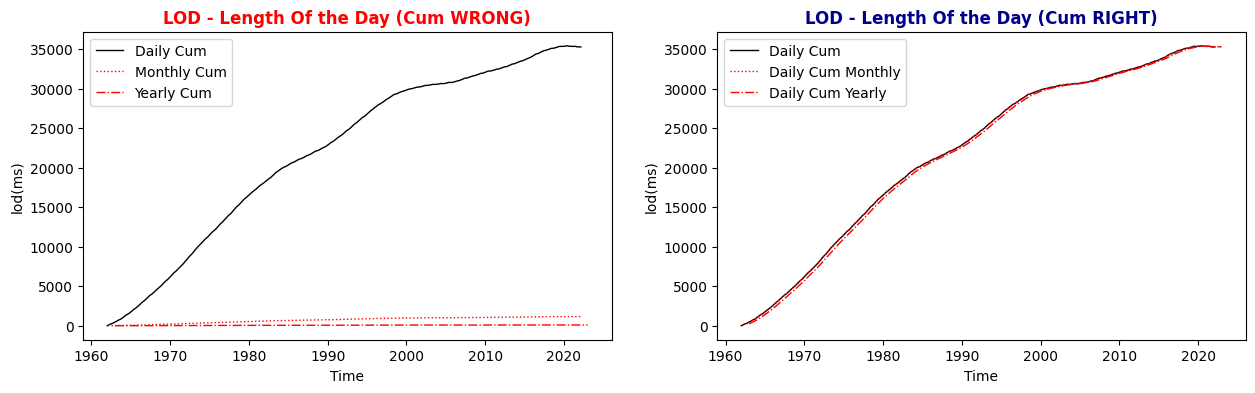

In [68]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,4))

sns.lineplot(x=df.index, y=df['lod(ms)'].cumsum(),label='Daily Cum',color='k',linestyle='-',lw=1,ax=ax1)
sns.lineplot(x=df_month.index, y=df_month['lod(ms)'].cumsum(),label='Monthly Cum',color='r',linestyle=':',lw=1,ax=ax1)
sns.lineplot(x=df_year.index, y=df_year['lod(ms)'].cumsum(),label='Yearly Cum',color='r',linestyle='-.',lw=1,ax=ax1)

ax1.set_title('LOD - Length Of the Day (Cum WRONG)',weight='bold',color='r')
ax1.set_xlabel('Time')

sns.lineplot(x=df.index, y=df['lod(ms)'].cumsum(),label='Daily Cum',color='k',linestyle='-',lw=1,ax=ax2)
sns.lineplot(x=df['lod(ms)'].cumsum().resample('ME').mean().index, y=df['lod(ms)'].cumsum().resample('ME').mean(),label='Daily Cum Monthly',color='r',linestyle=':',lw=1,ax=ax2)
sns.lineplot(x=df['lod(ms)'].cumsum().resample('YE').mean().index, y=df['lod(ms)'].cumsum().resample('YE').mean(),label='Daily Cum Yearly',color='r',linestyle='-.',lw=1,ax=ax2)

ax2.set_title('LOD - Length Of the Day (Cum RIGHT)',weight='bold',color='darkblue')
ax2.set_xlabel('Time')

plt.show()

# Exercício 1. **Time Series**

Construa um modelo ARIMA para prever a **variação acumulada do LOD (LOD accum) ANUAL**.






## 1.1. (2.0) Obtenha os parâmetros $(p,d,q)$ do modelo ARIMA

Considere o teste de estacionariedade **KPSS**, Kwiatkowski-Phillips-Schmidt-Shin (`from statsmodels.tsa.stattools import kpss`). Note, no KPSS, diferentemente do teste ADF a Hipótese Nula (H0) é que a série temporal é estacionária.

### Teste de estacionariedade **KPSS**, $d$



In [69]:
df.index = pd.to_datetime(df[["year", "month", "day"]])

ts = df[['lod(ms)']].cumsum().resample('YE').mean()
ts.head()

,lod(ms)
1962-12-31,236.279118
1963-12-31,733.407214
1964-12-31,1392.497363
1965-12-31,2144.264740
1966-12-31,2993.562956


In [70]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series):
    result = kpss(series)
    print(f'Teste KPSS:')
    print(f'Estatística KPSS: {result[0]}')
    print(f'Valor-p: {result[1]}')
    if result[1] <= 0.05:
        print('A série temporal não é estacionária (rejeita H0)')
    else:
        print('A série temporal é estacionária (falha em rejeitar H0)')
    return result[1]

print('\n d=0')
kpss_test(ts)

print('\n d=1')
kpss_test(ts.diff().dropna())

print('\n d=2')
kpss_test(ts.diff().diff().dropna())


 d=0
Teste KPSS:
Estatística KPSS: 1.0768352865552586
Valor-p: 0.01
A série temporal não é estacionária (rejeita H0)

 d=1
Teste KPSS:
Estatística KPSS: 0.9904946495762573
Valor-p: 0.01
A série temporal não é estacionária (rejeita H0)

 d=2
Teste KPSS:
Estatística KPSS: 0.2196969030641756
Valor-p: 0.1
A série temporal é estacionária (falha em rejeitar H0)


/tmp/ipython-input-4277155046.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series)
/tmp/ipython-input-4277155046.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series)
/tmp/ipython-input-4277155046.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series)


np.float64(0.1)

In [7]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print(f'Teste ADF:')
    print(f'Estatística ADF: {result[0]}')
    print(f'Valor-p: {result[1]}')
    if result[1] <= 0.05:
        print('A série temporal é estacionária (rejeita H0)')
    else:
        print('A série temporal não é estacionária (falha em rejeitar H0)')
    return result[1]

print('\n d=0')
adf_test(ts)


 d=0
Teste ADF:
Estatística ADF: -3.0584536559945787
Valor-p: 0.02978452538480977
A série temporal é estacionária (rejeita H0)


np.float64(0.02978452538480977)

### Auto-correlação e Correlação Parcial, ACF e PACF, **$q, p$**



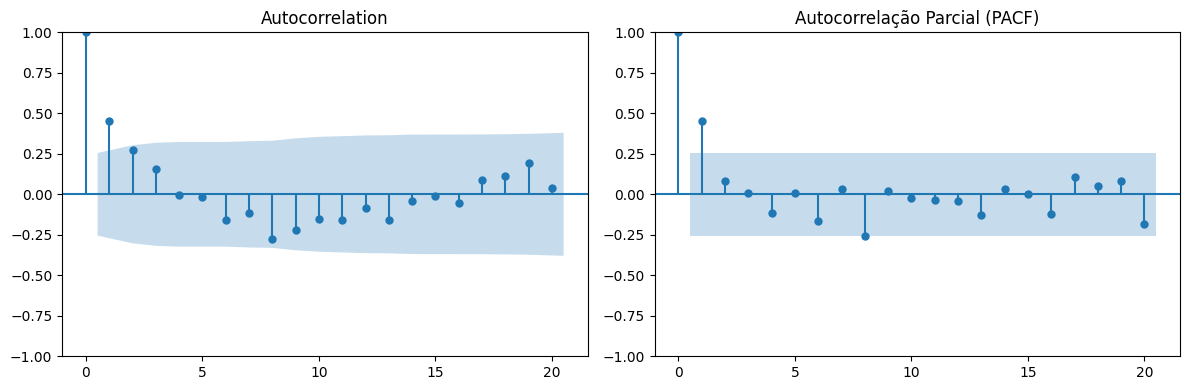

In [71]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(12, 4))

plot_acf(ts.diff().diff().dropna(), lags=20, ax=ax1)
ax2.set_title('Autocorrelação (ACF)')

plot_pacf(ts.diff().diff().dropna(), lags=20, ax=ax2)
ax2.set_title('Autocorrelação Parcial (PACF)')

plt.tight_layout()
plt.show()



$$ARIMA(1,2,1)(0,0,0,0)$$


## 1.2. (1.5) Forecast, `model1`

Com os parâmetros obtidos faça um modelo com os 80% dos dados mais antigos e analise o erro de previsão para os 20% mais recentes. Salve esse modelo como `model1`, você pode querer emprega-lo mais adiante.

In [9]:
end_train = int(len(ts)*0.8)

train, test = ts.iloc[0:end_train], ts.iloc[end_train::]

display(train.tail())
display(test.head())

,lod(ms)
2005-12-31,30779.955643
2006-12-31,30986.204883
2007-12-31,31318.020546
2008-12-31,31617.402453
2009-12-31,31929.529331


,lod(ms)
2010-12-31,32214.672978
2011-12-31,32458.329399
2012-12-31,32756.715700
2013-12-31,33103.918950
2014-12-31,33467.728864


                               SARIMAX Results                                
Dep. Variable:                lod(ms)   No. Observations:                   48
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -261.507
Date:                Mon, 25 Aug 2025   AIC                            529.015
Time:                        13:21:49   BIC                            534.501
Sample:                    12-31-1962   HQIC                           531.070
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6915      0.282      2.456      0.014       0.140       1.243
ma.L1         -0.2653      0.335     -0.792      0.428      -0.922       0.391
sigma2      5057.1795   1051.139      4.811      0.0

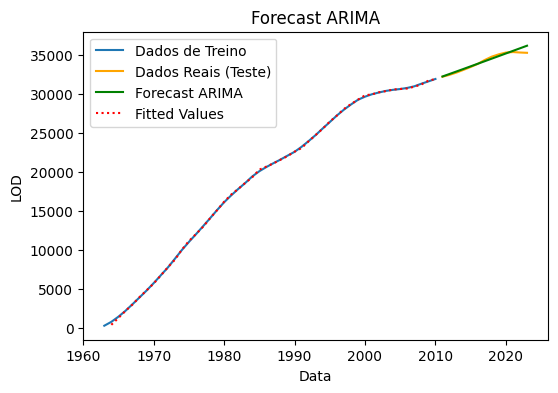

2010-12-31    32247.750985
2011-12-31    32570.186963
2012-12-31    32895.536996
2013-12-31    33222.901997
2014-12-31    33551.660277
2015-12-31    33881.381959
2016-12-31    34211.769801
2017-12-31    34542.618268
2018-12-31    34873.785242
2019-12-31    35205.172452
2020-12-31    35536.711947
2021-12-31    35868.356742
2022-12-31    36200.074348
Freq: YE-DEC, Name: predicted_mean, dtype: float64


In [10]:
order = (1,2,1)

# Treinar o modelo SARIMA
# model = ARIMA(train, order=order, seasonal_order=seasonal_order)
model_1 = ARIMA(train, order=order)
model_1 = model_1.fit()

print(model_1.summary())

# forecast = model_fit.forecast(steps=forecast_steps) # Esta é a forma antiga
# Usar predict para um forecast mais robusto com índices
forecast = model_1.predict(start=test.index[0], end=test.index[-1])

# Visualizar o forecast
plt.figure(figsize=(6,4))
plt.plot(train.index, train, label='Dados de Treino')
plt.plot(test.index, test, label='Dados Reais (Teste)', color='orange')
plt.plot(test.index, forecast, label='Forecast ARIMA', color='green')
plt.plot(model_1.fittedvalues[1::], label='Fitted Values', color='red',linestyle=':')

plt.title('Forecast ARIMA')
plt.xlabel('Data')
plt.ylabel('LOD')
plt.legend()
plt.show()

print(forecast)


### Análise dos Resíduos

Faça quaisquer dos testes estudados e verifique a normalidade dos resíduos.

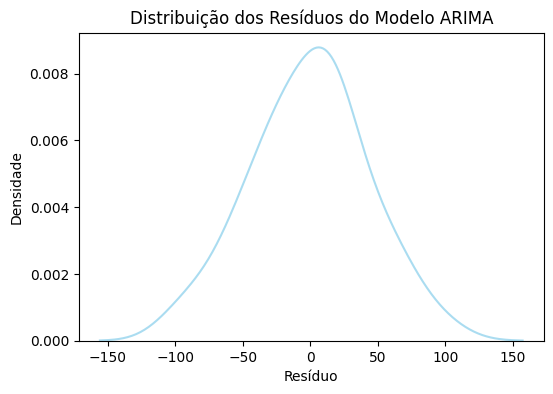

In [11]:
residuals = model_1.resid

plt.figure(figsize=(6, 4))
sns.kdeplot(residuals[ np.abs(residuals) < 100 ], alpha=0.7, color='skyblue')
plt.title('Distribuição dos Resíduos do Modelo ARIMA')
plt.xlabel('Resíduo')
plt.ylabel('Densidade')
# plt.xlim(-30, 30)

plt.show()

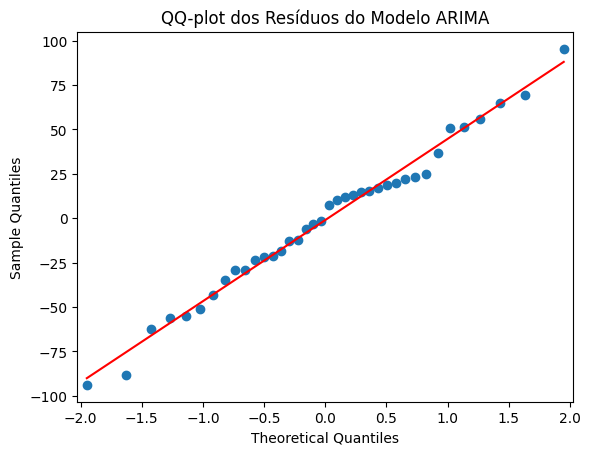

In [12]:
from statsmodels.graphics.api import qqplot

# Gerar o QQ-plot dos resíduos
qqplot(residuals[ np.abs(residuals) < 100 ], line='r')
plt.title('QQ-plot dos Resíduos do Modelo ARIMA')
plt.show()

### Testes de normalidade do erro

In [13]:
from scipy.stats import jarque_bera

# Teste de Jarque-Bera
# H₀ (nula): os resíduos têm distribuição normal.
jb_stat, jb_pvalue = jarque_bera(residuals[~np.isnan(residuals)])

print(f'Teste de Jarque-Bera para Normalidade dos Resíduos:')
print(f'Estatística de teste: {jb_stat:.3f}')
print(f'Valor-p: {jb_pvalue:.3f}')
if jb_pvalue > 0.05:
    print('Os resíduos parecem ser normalmente distribuídos (não rejeitar H0)')
else:
    print('Os resíduos não parecem ser normalmente distribuídos (rejeita H0)')

Teste de Jarque-Bera para Normalidade dos Resíduos:
Estatística de teste: 38.187
Valor-p: 0.000
Os resíduos não parecem ser normalmente distribuídos (rejeita H0)


In [14]:
from scipy.stats import shapiro

# Teste de Shapiro-Wilk
# H₀ (nula): os resíduos têm distribuição normal.
sw_stat, sw_pvalue = shapiro(residuals[~np.isnan(residuals)])

print(f'Teste de Shapiro-Wilk para Normalidade dos Resíduos:')
print(f'Estatística de teste: {sw_stat:.3f}')
print(f'Valor-p: {sw_pvalue:.3f}')
if sw_pvalue > 0.05:
    print('Os resíduos parecem ser normalmente distribuídos (não rejeitar H0)')
else:
    print('Os resíduos não parecem ser normalmente distribuídos (rejeita H0)')


Teste de Shapiro-Wilk para Normalidade dos Resíduos:
Estatística de teste: 0.906
Valor-p: 0.001
Os resíduos não parecem ser normalmente distribuídos (rejeita H0)


### Correlação dos resíduos

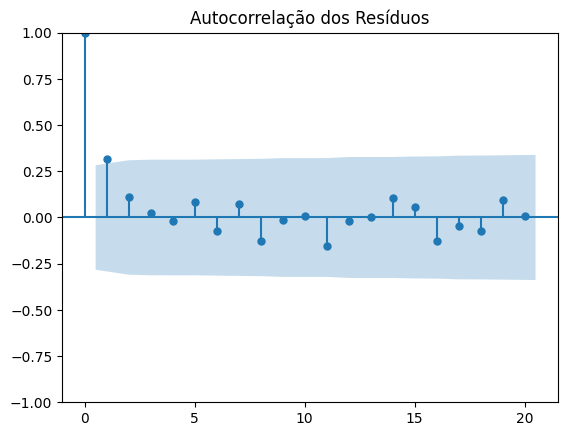

In [15]:
# Testar a autocorrelação dos resíduos (idealmente, os resíduos não devem ser correlacionados)
plot_acf(residuals, lags=20)
plt.title('Autocorrelação dos Resíduos')
plt.show()

### Análise do Erro

Qual a raiz do erro médio quadrático e o percentual de erro das predições sobre o conjunto de teste e de treinamento?

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calcular o RMSE
rmse = sqrt(mean_squared_error(test, forecast))
print(f'RMSE do conjunto de teste: {rmse:.2f}')

mape = np.mean(np.abs(np.array(test) - np.array(forecast)) / np.array(test)) * 100
print(f'MAPE do conjunto de teste: {mape:.2f} %')

# Calcular o RMSE
rmse = sqrt(mean_squared_error(train[1::], model_1.fittedvalues[1::]))
print(f'RMSE do conjunto de treinamento: {rmse:.2f}')

mape = np.mean(np.abs(np.array(train[1::]) - np.array(model_1.fittedvalues[1::])) / np.array(train[1::])) * 100
print(f'MAPE do conjunto de treinamento: {mape:.2f} %')

RMSE do conjunto de teste: 322.28
MAPE do conjunto de teste: 4.07 %
RMSE do conjunto de treinamento: 90.06
MAPE do conjunto de treinamento: 179.86 %


## 1.3. (2.0) Forecast, `model2`

Com os parâmetros obtidos apresentam um erro bastante satisfatório e o `model1` parece ser um bom modelo. Crie agora um segundo modelo, `model2`, com os mesmos parâmetros $(p,d,q)$ de antes, mas no lugar de empregar somente os dados de treinamento empregue todos os dados disponíveis.

Faça em seguida uma previsão dos dois modelos para o ano de 2050. Compare e discuta os resultados obtidos.

                               SARIMAX Results                                
Dep. Variable:                lod(ms)   No. Observations:                   61
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -335.896
Date:                Mon, 25 Aug 2025   AIC                            677.792
Time:                        13:21:54   BIC                            684.025
Sample:                    12-31-1962   HQIC                           680.225
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6349      0.246      2.576      0.010       0.152       1.118
ma.L1         -0.1899      0.302     -0.629      0.529      -0.782       0.402
sigma2      5146.2136    965.760      5.329      0.0

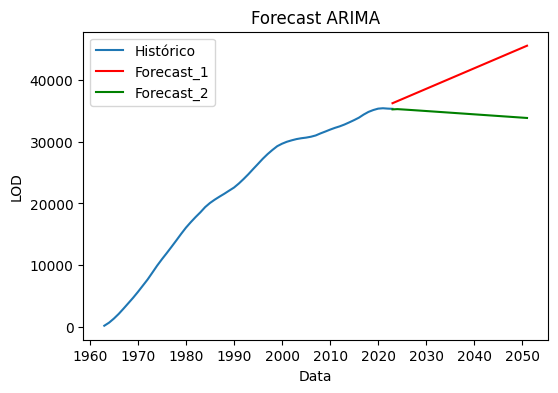

Predição model_1 para 2050: 45492.37
Predição model_2 para 2050: 33814.96


In [17]:
order = (1,2,1)

# Treinar o modelo SARIMA
# model = ARIMA(train, order=order, seasonal_order=seasonal_order)
model_2 = ARIMA(ts, order=order)
model_2 = model_2.fit()

print(model_2.summary())

# Fazer o forecast
forecast_1 = model_1.predict(start=test.index[-1], end='2050-12-31')
forecast_2 = model_2.predict(start=test.index[-1], end='2050-12-31')

# Visualizar o forecast
plt.figure(figsize=(6,4))
plt.plot(ts, label='Histórico')
plt.plot(forecast_1, label='Forecast_1', color='red')
plt.plot(forecast_2, label='Forecast_2', color='green')

plt.title('Forecast ARIMA')
plt.xlabel('Data')
plt.ylabel('LOD')
plt.legend()
plt.show()

print(f'Predição model_1 para 2050: {forecast_1.iloc[-1]:.2f}')
print(f'Predição model_2 para 2050: {forecast_2.iloc[-1]:.2f}')

# Exercício 2. **Testes de Significância, Wine Quality**

Este é um conjunto de dados sobre qualidade de vinhos. Empregue esses dados para fazer análises e chegar a conclusões sobre a qualidade dos vinhos (ou alguma outra característica) criando e aplicado 3 testes de significância:

1. Um t-test
2. Um chi-test  
3. Uma ANOVA  

Para cada teste você deve:

1. Enunciar a sua pergunta
2. Executar o teste
3. Apresentar a sua conclusão

Em cada caso **pode ser necessário transformar variáveis, como por exemplo, fazer a discretização de alguma variável** para adequação do teste, e verificar **pressupostos** mínimos de cada teste.





In [18]:
from scipy import stats
from sklearn.datasets import load_wine

wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['quality'] = wine.target

df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,quality
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


## 2.1. t-test (1.0)

### Pergunta

Existe uma diferença significativa na alcalinidade das cinzas (`alcalinity_of_ash`) entre os vinhos de menor qualidade (0) e maior (1)?


### Teste

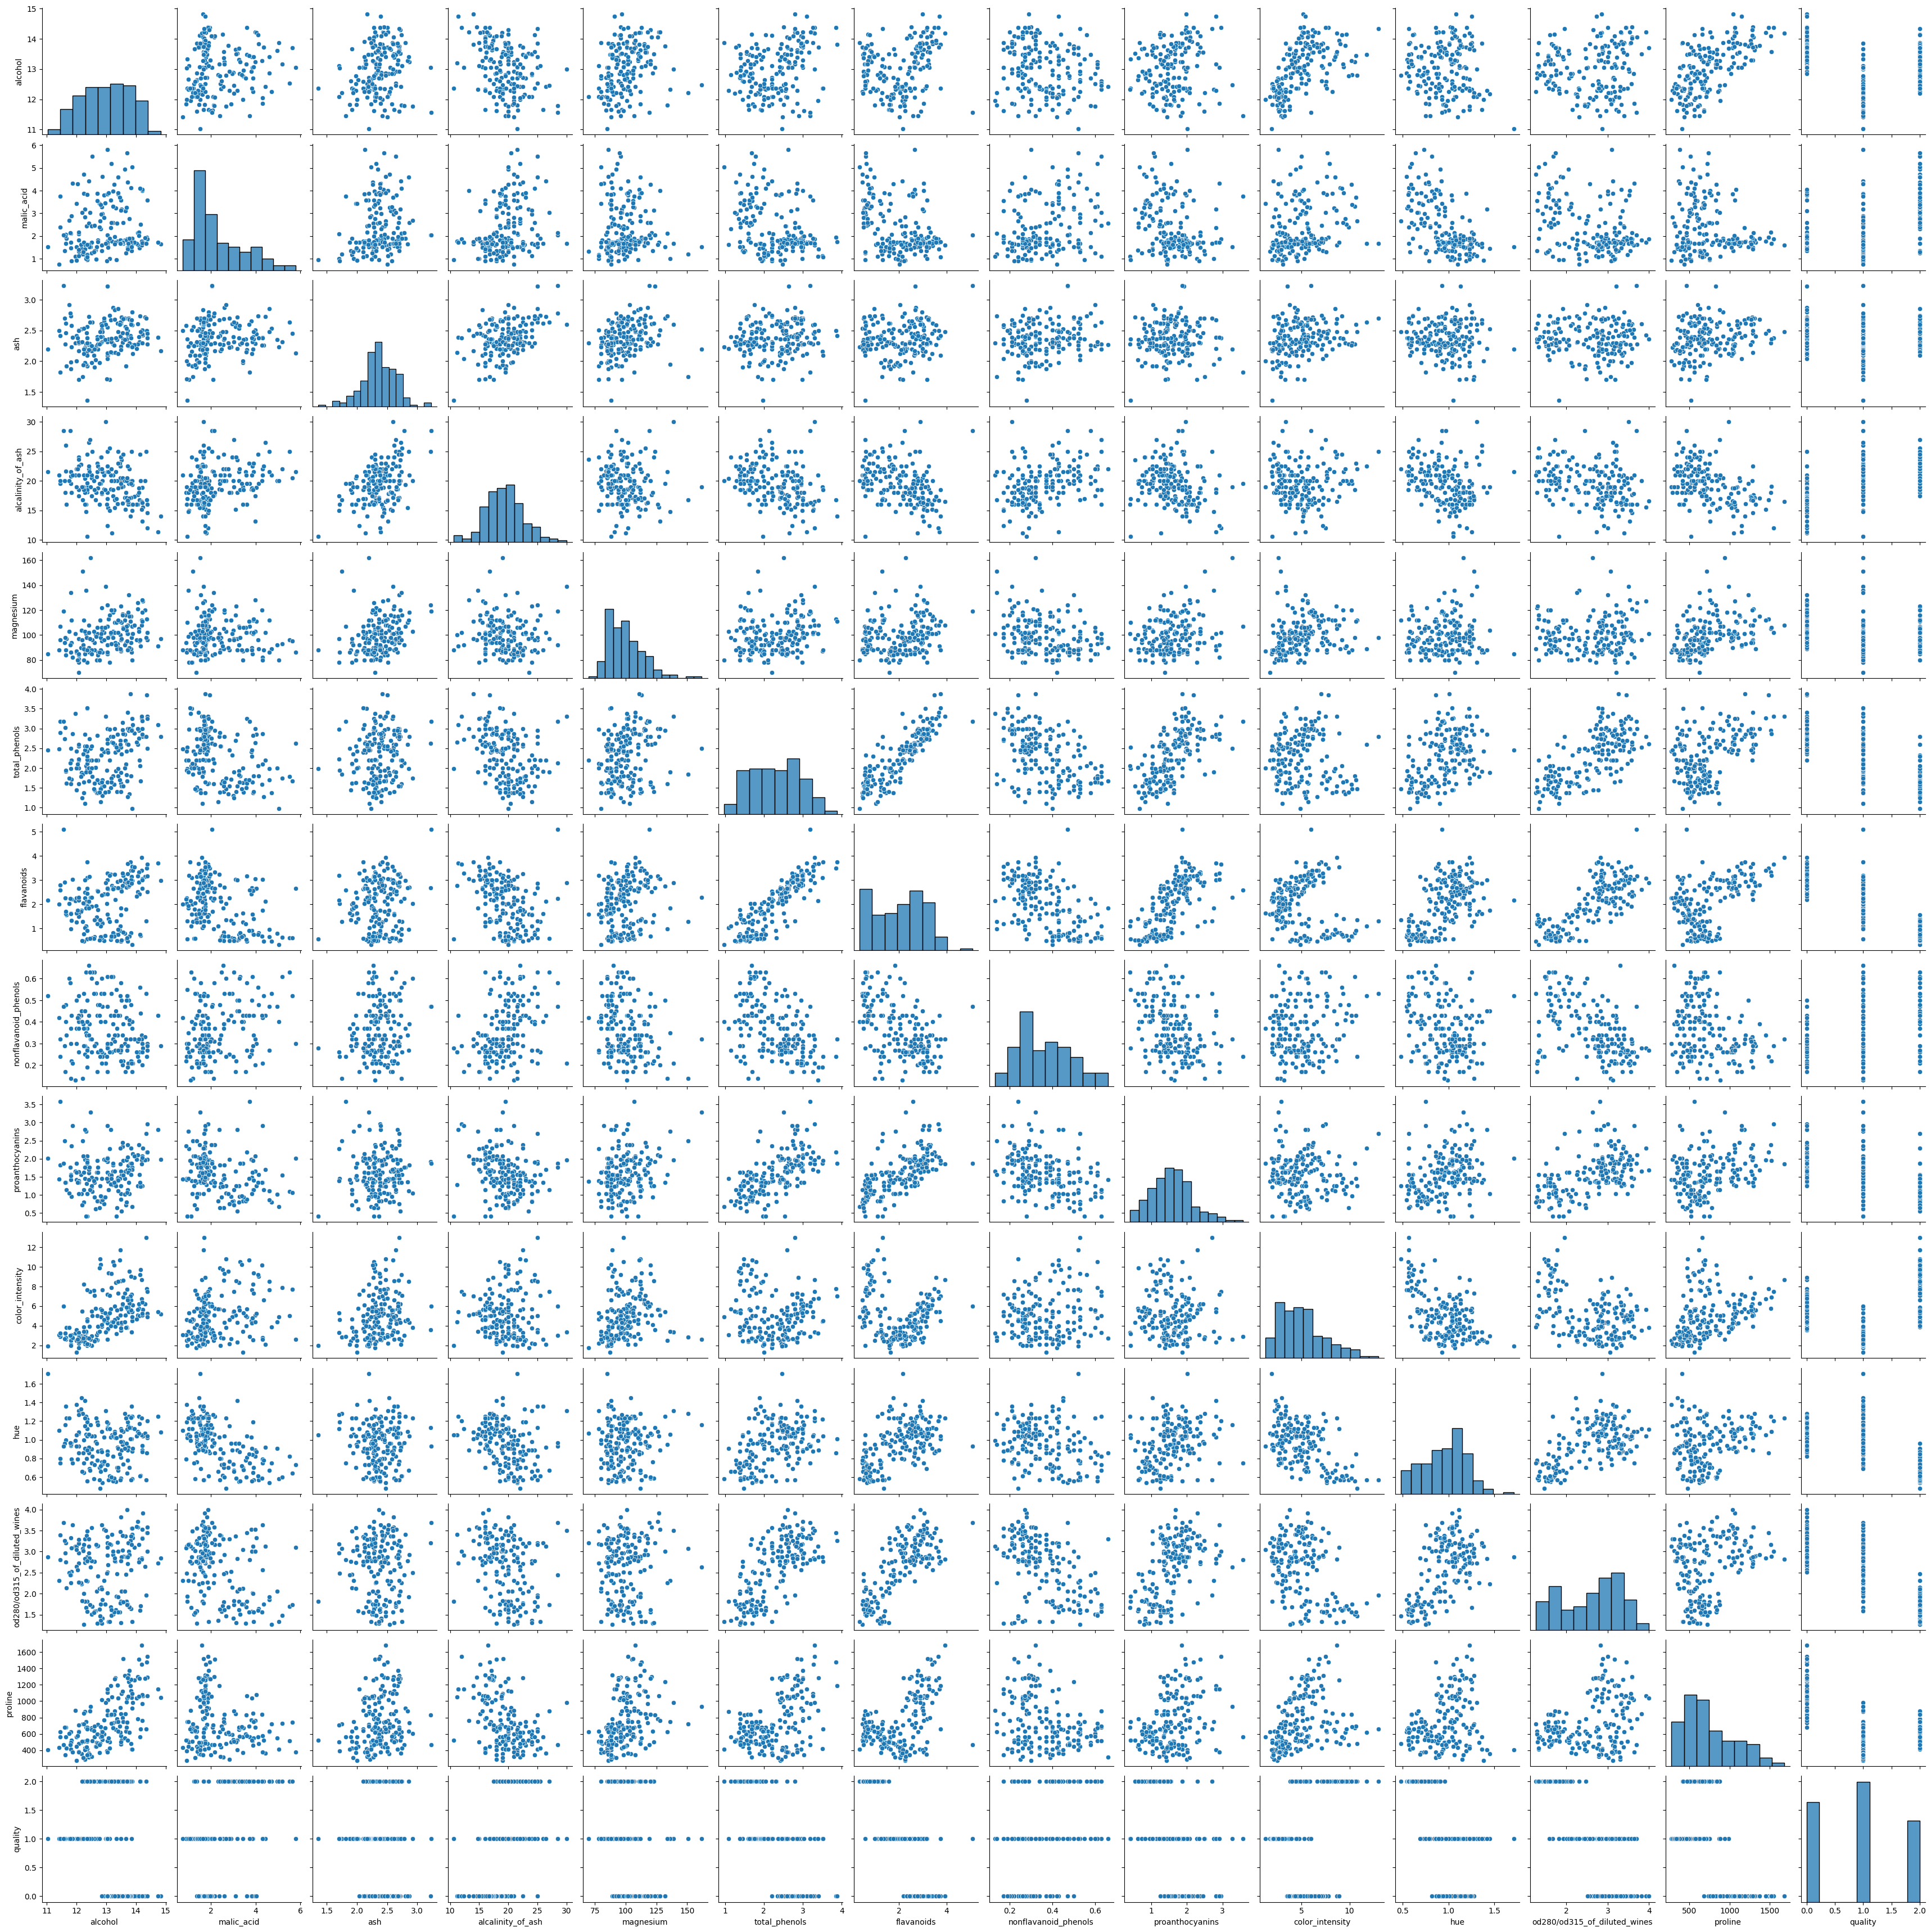

In [19]:
sns.pairplot(df)
plt.show()

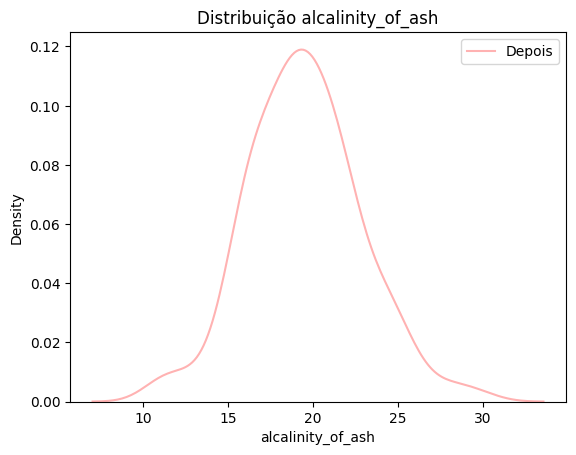

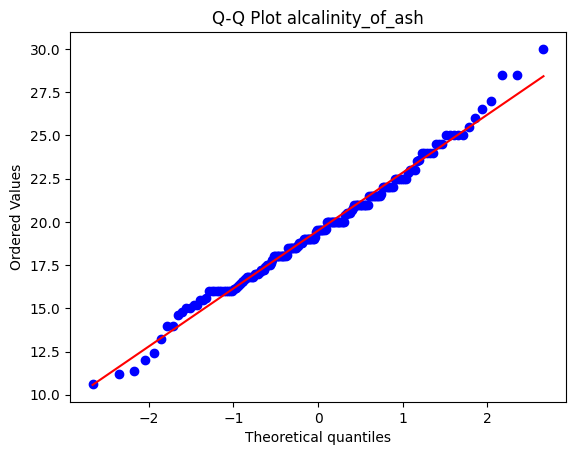

In [20]:
import scipy.stats as stats

sns.kdeplot(df['alcalinity_of_ash'], color='red', label='Depois',alpha=0.3)
plt.legend()
plt.title('Distribuição alcalinity_of_ash')
plt.show()

stats.probplot(df['alcalinity_of_ash'], dist="norm", plot=plt)
plt.title('Q-Q Plot alcalinity_of_ash')
plt.show()

In [21]:
stat, pvalue = stats.shapiro(df['alcalinity_of_ash'])

print("Estatística Shapiro-Wilk:", stat)
print("Valor-p:", pvalue)
print()

alpha = 0.05
if pvalue > alpha:
    print('Os dados parecem ser normalmente distribuídos (não rejeitar H0)')
else:
    print('Os dados não parecem ser normalmente distribuídos (rejeita H0)')

Estatística Shapiro-Wilk: 0.9902253552856983
Valor-p: 0.263868844753376

Os dados parecem ser normalmente distribuídos (não rejeitar H0)


In [22]:
stat, pvalue = stats.levene(df[df['quality'] == 0]['alcalinity_of_ash'], df[df['quality'] == 2]['alcalinity_of_ash'])

print("Estatística Levene:", stat)
print("Valor p:", pvalue)
print()

alpha = 0.05
if pvalue < 0.05:
    print("Dados não têm variâncias estatisticamente iguais.")
else:
    print("Dados têm variâncias estatisticamente iguais.")

Estatística Levene: 0.010282541623018296
Valor p: 0.9194240454666116

Dados têm variâncias estatisticamente iguais.


In [23]:
# Filtrar os dados para obter a intensidade da cor para os grupos de qualidade 0 e 2
color_quality_1 = df[df['quality'] == 0]['alcalinity_of_ash']
color_quality_2 = df[df['quality'] == 2]['alcalinity_of_ash']

# Realizar o teste t independente
t_statistic, p_value = stats.ttest_ind(color_quality_1, color_quality_2)

print(f"\nResultado do Teste t:")
print(f"Estatística t: {t_statistic:.4f}")
print(f"Valor-p: {p_value:.4f}")




Resultado do Teste t:
Estatística t: -9.3040
Valor-p: 0.0000


### Resultado

In [24]:
alpha = 0.05
if p_value < alpha:
    print(f"Com um valor-p ({p_value:.4f}) menor que o nível de significância ({alpha}), rejeitamos a hipótese nula.")
    print("\nExiste evidência significativa para concluir que a alcalinity_of_ash difere entre os vinhos de maior e menor qualidade.")
else:
    print(f"Com um valor-p ({p_value:.4f}) maior que o nível de significância ({alpha}), não rejeitamos a hipótese nula.")
    print("\nNão há evidência significativa para concluir que a alcalinity_of_ash difere entre os vinhos de maior e menor qualidade.")

Com um valor-p (0.0000) menor que o nível de significância (0.05), rejeitamos a hipótese nula.

Existe evidência significativa para concluir que a alcalinity_of_ash difere entre os vinhos de maior e menor qualidade.


## 2.2. chi-test (1.0)

### Pergunta

Existe uma dependência significativa entre a qualidade do vinho e categorias de acidez fixa (baixa, média, alta)?

### Teste

In [25]:
# Usando qcut para discretizar os valores
df['fixed_acidity_cat'] = pd.qcut(df['malic_acid'], q=3, labels=['Baixa', 'Média', 'Alta'])

# Executar o teste qui-quadrado
# Criar uma tabela de contingência
contingency_table = pd.crosstab(df['fixed_acidity_cat'], df['quality'])

# Realizar o teste qui-quadrado
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# 3. Apresentar a sua conclusão
print(f"\nResultado do Teste Qui-Quadrado:")
print(f"Estatística Qui-Quadrado: {chi2:.4f}")
print(f"Valor-p: {p_value:.4f}")


Resultado do Teste Qui-Quadrado:
Estatística Qui-Quadrado: 81.8844
Valor-p: 0.0000


### Resultado

In [26]:
alpha = 0.05
if p_value < alpha:
    print(f"Com um valor-p ({p_value:.4f}) menor que o nível de significância ({alpha}), rejeitamos a hipótese nula (independência).")
    print("\nExiste evidência significativa de dependência entre a qualidade do vinho e as categorias de acidez fixa.")
else:
    print(f"Com um valor-p ({p_value:.4f}) maior que o nível de significância ({alpha}), não rejeitamos a hipótese nula (independência).")
    print("\nNão há evidência significativa de dependência entre a qualidade do vinho e as categorias de acidez fixa.")

Com um valor-p (0.0000) menor que o nível de significância (0.05), rejeitamos a hipótese nula (independência).

Existe evidência significativa de dependência entre a qualidade do vinho e as categorias de acidez fixa.


## 2.3. ANOVA (1.0)



### Pergunta


Existe uma diferença significativa no teor alcoólico entre os diferentes grupos de qualidade de vinho?

### Teste

Uma das principais suposições da ANOVA é que os dados de cada grupo devem seguir uma distribuição aproximadamente normal.

In [27]:
for i in range(3):
  stat, pvalue = stats.shapiro(df[df['quality'] == 2]['alcohol'])

  print("\nNormalidade `alcohol` para vinhos de Qualidade:", i)
  print("Estatística Shapiro-Wilk:", stat)
  print("Valor-p:", pvalue)
  print()

  alpha = 0.05
  if pvalue > alpha:
      print('Os dados parecem ser normalmente distribuídos (não rejeitar H0)')
  else:
      print('Os dados não parecem ser normalmente distribuídos (rejeita H0)')


Normalidade `alcohol` para vinhos de Qualidade: 0
Estatística Shapiro-Wilk: 0.981467604122252
Valor-p: 0.6408387007191338

Os dados parecem ser normalmente distribuídos (não rejeitar H0)

Normalidade `alcohol` para vinhos de Qualidade: 1
Estatística Shapiro-Wilk: 0.981467604122252
Valor-p: 0.6408387007191338

Os dados parecem ser normalmente distribuídos (não rejeitar H0)

Normalidade `alcohol` para vinhos de Qualidade: 2
Estatística Shapiro-Wilk: 0.981467604122252
Valor-p: 0.6408387007191338

Os dados parecem ser normalmente distribuídos (não rejeitar H0)


In [28]:
for i in range(1,3):
  stat, pvalue = stats.levene(df[df['quality'] == 0]['alcohol'], df[df['quality'] == i]['alcohol'])

  print("\nSemelhança de variância de `alcohol` para vinhos de Qualidade:", i, " com o de Qualidade 0.")
  print("Estatística Levene:", stat)
  print("Valor p:", pvalue)
  print()

  alpha = 0.05
  if pvalue < 0.05:
      print("Dados não têm variâncias estatisticamente iguais.")
  else:
      print("Dados têm variâncias estatisticamente iguais.")


Semelhança de variância de `alcohol` para vinhos de Qualidade: 1  com o de Qualidade 0.
Estatística Levene: 0.3124941230878048
Valor p: 0.5771304347333492

Dados têm variâncias estatisticamente iguais.

Semelhança de variância de `alcohol` para vinhos de Qualidade: 2  com o de Qualidade 0.
Estatística Levene: 1.4829753126093375
Valor p: 0.22603913840265982

Dados têm variâncias estatisticamente iguais.


In [29]:
groups = df.groupby('quality')['alcohol']

# Realizar o teste ANOVA
f_statistic, p_value = stats.f_oneway(*[group for name, group in groups])

# Apresentar a sua conclusão
print(f"\nResultado do Teste ANOVA:")
print(f"Estatística F: {f_statistic:.4f}")
print(f"Valor-p: {p_value:.4f}")


Resultado do Teste ANOVA:
Estatística F: 135.0776
Valor-p: 0.0000


### Resultado

In [30]:
alpha = 0.05
if p_value < alpha:
    print(f"Com um valor-p ({p_value:.4f}) menor que o nível de significância ({alpha}), rejeitamos a hipótese nula.")
    print("\nExiste evidência significativa para concluir que o teor alcoólico médio difere entre os diferentes grupos de qualidade de vinho.")
else:
    print(f"Com um valor-p ({p_value:.4f}) maior que o nível de significância ({alpha}), não rejeitamos a hipótese nula.")
    print("\nNão há evidência significativa para concluir que o teor alcoólico médio difere entre os diferentes grupos de qualidade de vinho.")

Com um valor-p (0.0000) menor que o nível de significância (0.05), rejeitamos a hipótese nula.

Existe evidência significativa para concluir que o teor alcoólico médio difere entre os diferentes grupos de qualidade de vinho.



# Exercício 3. Gráfico LOD $\times$ China

No exercício 1 você observou que o LOD vem aumentando ao longo do tempo (**LOD accum**) e que isso, em boa parte, tem relação com a atividade humana, particularmente grandes construções e grandes deslocamentos e água e terra na **China**.

Empregue os dados a seguir para produzir um gráfico o mais próximo possível do abaixo.

## Dados de Produto Interno Bruto

In [31]:
gdp = pd.read_csv('https://github.com/Rogerio-mack/craam/raw/main/total_gdp_us_inflation_adjusted.csv')
gdp.head()

,country,1959,1960,1961,1962,1963,1964,1965,1966,1967,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.72B,2.68B,2.79B,2.8B,2.96B,3.03B,3.09B,NaN,NaN,NaN
1,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16B,18.1B,19.1B,19.6B,19.9B,20.4B,20.9B,21.1B,22B,21.5B
2,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,96.4B,105B,110B,115B,116B,113B,113B,111B,110B,106B
3,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.7B,10.8B,10.9B,11.1B,11.4B,11.8B,12.2B,12.7B,13B,12.6B
4,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.93B,2.78B,2.68B,2.75B,2.79B,2.89B,2.9B,2.95B,3.01B,2.65B


## Dados das Usinas Hidroelétricas Chinesas

In [32]:
usinas = pd.read_excel('https://github.com/Rogerio-mack/craam/raw/main/usinas_hydro_china.xlsx')
usinas = usinas[ usinas['País'] == 'China']
usinas['Ano de construção'] = usinas['Ano de construção'].apply(lambda x: x.split('/')[0].split('-')[0])
usinas.head()

,Nome,País,Rio,Capacidade instalada (MW),Produção anual (TW-hora)[nota 1],Área inundada (km²),Localização,Ano de construção
1,Três Gargantas,China,Yangtze,22.500,"103,1",1.084,"30° 49′ 42″ N, 111° 00′ 08″ L",2008
3,Xiluodu,China,Jinsha,13.860,"55,2",NaN,"28° 15′ 36″ N, 103° 38′ 55″ L",2014
6,Wudongde,China,Jinsha,10.200,"39,0",NaN,"26° 20′ 02″ N, 102° 37′ 48″ L",2020
9,Xiangjiaba,China,Jinsha,6.448,"30,88","95,6","28° 38′ 48″ N, 104° 23′ 33″ L",2014
10,Longtan,China,Hongshui,6.426,"18,7",NaN,"25° 01′ 38″ N, 107° 02′ 51″ L",2007


## Gráfico (2,0)

1. No formato e incluídos **dados de GDP** (0.5).
2. No formato e incluídos dados das **5 maiores (`Capacidade instalada (MW)`) Usinas** (1.0).



In [33]:
df = pd.read_csv('https://github.com/Introducao-Series-Temporais-em-Python/Book/raw/main/Data/Delta_LOD.csv',sep=';',usecols=['year', 'month', 'day', 'lod(ms)', 'sig(ms)'])
df.head()

,year,month,day,lod(ms),sig(ms)
0,1962,1,1,1.723,1.4
1,1962,1,2,1.669,1.4
2,1962,1,3,1.582,1.4
3,1962,1,4,1.496,1.4
4,1962,1,5,1.416,1.4


In [34]:
gdp = gdp[gdp.country.isin(['China'])]

for c in gdp.drop(columns='country'):
  if any(gdp[c].isnull()):
    gdp = gdp.drop(columns=c)

for c in gdp.drop(columns='country'):
  gdp.loc[:,c] = gdp.loc[:,c].replace({'k': '*1e3', 'M': '*1e6', 'B': '*1e9', 'TR': '*1e12'}, regex=True).map(pd.eval).astype(int) / 1000

gdp = pd.melt(gdp, id_vars=['country'])
gdp.columns = ['country', 'year', 'gdp']
gdp.year = gdp.year.astype(int)

gdp.head()

,country,year,gdp
0,China,1959,159000000.0
1,China,1960,116000000.0
2,China,1961,109000000.0
3,China,1962,120000000.0
4,China,1963,142000000.0


In [35]:
df = df.merge(gdp,left_on='year',right_on='year',how='left')
df.index = pd.to_datetime(df[["year", "month", "day"]])
df.head()

,year,month,day,lod(ms),sig(ms),country,gdp
1962-01-01,1962,1,1,1.723,1.4,China,120000000.0
1962-01-02,1962,1,2,1.669,1.4,China,120000000.0
1962-01-03,1962,1,3,1.582,1.4,China,120000000.0
1962-01-04,1962,1,4,1.496,1.4,China,120000000.0
1962-01-05,1962,1,5,1.416,1.4,China,120000000.0


In [36]:
usinas['Capacidade instalada (MW)'] = usinas['Capacidade instalada (MW)'].apply(lambda x: x.replace('.',''))
usinas['Capacidade instalada (MW)'] = usinas['Capacidade instalada (MW)'].astype(int)
usinas.head()

,Nome,País,Rio,Capacidade instalada (MW),Produção anual (TW-hora)[nota 1],Área inundada (km²),Localização,Ano de construção
1,Três Gargantas,China,Yangtze,22500,"103,1",1.084,"30° 49′ 42″ N, 111° 00′ 08″ L",2008
3,Xiluodu,China,Jinsha,13860,"55,2",NaN,"28° 15′ 36″ N, 103° 38′ 55″ L",2014
6,Wudongde,China,Jinsha,10200,"39,0",NaN,"26° 20′ 02″ N, 102° 37′ 48″ L",2020
9,Xiangjiaba,China,Jinsha,6448,"30,88","95,6","28° 38′ 48″ N, 104° 23′ 33″ L",2014
10,Longtan,China,Hongshui,6426,"18,7",NaN,"25° 01′ 38″ N, 107° 02′ 51″ L",2007


In [37]:
usinas_big = usinas.nlargest(5,'Capacidade instalada (MW)')
usinas_big

,Nome,País,Rio,Capacidade instalada (MW),Produção anual (TW-hora)[nota 1],Área inundada (km²),Localização,Ano de construção
1,Três Gargantas,China,Yangtze,22500,"103,1",1.084,"30° 49′ 42″ N, 111° 00′ 08″ L",2008
3,Xiluodu,China,Jinsha,13860,"55,2",NaN,"28° 15′ 36″ N, 103° 38′ 55″ L",2014
6,Wudongde,China,Jinsha,10200,"39,0",NaN,"26° 20′ 02″ N, 102° 37′ 48″ L",2020
9,Xiangjiaba,China,Jinsha,6448,"30,88","95,6","28° 38′ 48″ N, 104° 23′ 33″ L",2014
10,Longtan,China,Hongshui,6426,"18,7",NaN,"25° 01′ 38″ N, 107° 02′ 51″ L",2007


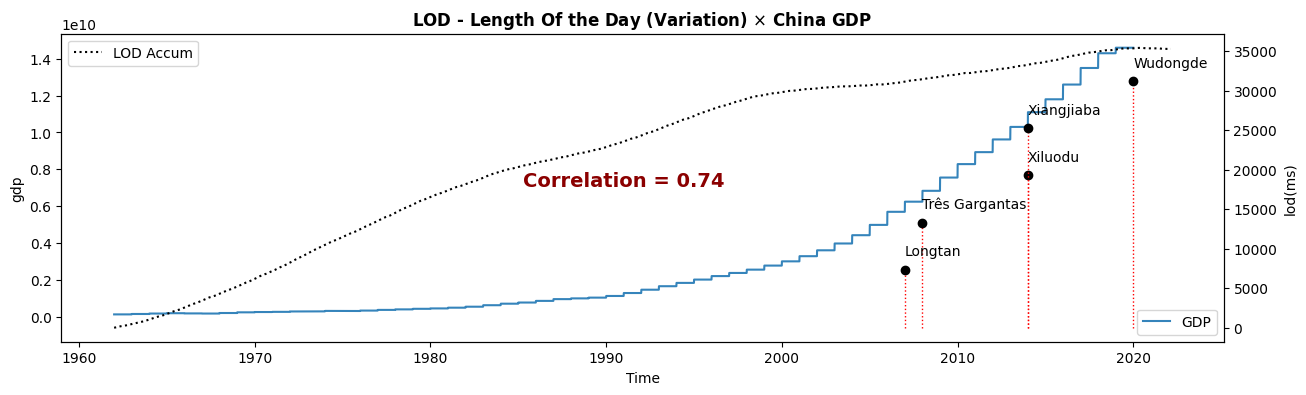

In [38]:
fig, ax = plt.subplots(figsize=(15,4))

sns.lineplot(x=df.index, y=df.gdp, alpha=0.9, label='GDP',ax=ax)
ax.legend(loc='lower right')

ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()

i=1
for _, row in usinas_big.sort_values(['Ano de construção']).iterrows():
  ax.vlines(pd.to_datetime(row['Ano de construção']),ymin,ymax/(len(usinas_big)+1)*i,lw=1,linestyle=':',color='r')
  ax.plot(pd.to_datetime(row['Ano de construção']),ymax/(len(usinas_big)+1)*i,'ok')
  ax.text(pd.to_datetime(row['Ano de construção']),ymax/(len(usinas_big)+1)*i+ymax/20,row.Nome,c='k')
  i=i+1

correlation = df.gdp.corr(df['lod(ms)'].cumsum())
x_center = xmin + (xmax - xmin) / 2
y_center = ymin + (ymax - ymin) / 2

ax.text(x_center, y_center, f'Correlation = {correlation:.2f}', ha='center', va='center', fontsize=14, color='darkred',weight='bold')

ax2 = ax.twinx()
sns.lineplot(x=df.index, y=df['lod(ms)'].cumsum(),label='LOD Accum',ax=ax2,color='k',linestyle=':')

ax.set_title('LOD - Length Of the Day (Variation) $\\times$ China GDP',weight='bold')
ax.set_xlabel('Time')

plt.show()